In [30]:
import geopandas as gpd
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.visualization import ee_viz
from src.data import mtbs
from src.data import shape_processor
from src.data import gedi_pipeline
from src.data import k_nn
import ee
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from fitter import Fitter, get_common_distributions, get_distributions
from src.processing.recent_fires import gedi_matching, matching_analysis
from src.visualization.gedi_viz import geo_plot

import importlib
importlib.reload(gedi_pipeline)
importlib.reload(gedi_matching)
importlib.reload(matching_analysis)
from src.data.gedi_pipeline import get_severity

2023-06-05 22:36:02,180 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


In [21]:
ee.Authenticate()

In [7]:
ee.Initialize()

In [3]:
sierras = gpd.read_file("../../../data/shapefiles/sierras_convex_hull.shp")
firep_db = FirePerimetersDB('../../../data/fire_perimeters.gdb/')
sierra_firep = FirePerimeters(firep_db).filter_for_years(['2020']).filter_within_geometry(sierras)

In [10]:
gedi_gdf= gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/sierras_matched_lc_all_2x2.csv')
gedi_burned, gedi_unburned = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_gdf)

2023-06-05 21:08:37,213 DEBUG: Excluded shots on the burn boundaries, shots remaining:         9446235 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-05 21:08:37,517 DEBUG: Number of GEDI shots that burned at least once:                  1440937 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-05 21:08:38,630 DEBUG: Number of GEDI shots that never burned since 1984:         7852535 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-05 21:08:38,972 DEBUG: Number of shots that burned exactly once:                    1253729 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-05 21:08:39,130 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    771977 [in exclude_shots_on_burn_b

In [29]:
gedi_l2b = gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/gedi_l2b_sierras_matched_lc_all_2x2.csv')
gedi_burned_l2b, gedi_unburned_l2b = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_l2b)

2023-06-05 21:47:43,494 DEBUG: Excluded shots on the burn boundaries, shots remaining:         14968077 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-05 21:47:44,126 DEBUG: Number of GEDI shots that burned at least once:                  2184975 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-05 21:47:46,713 DEBUG: Number of GEDI shots that never burned since 1984:         12539296 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-05 21:47:47,689 DEBUG: Number of shots that burned exactly once:                    1891695 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-05 21:47:48,048 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    1192212 [in exclude_shots_on_bur

In [8]:
fire = sierra_firep.get_fire('NORTH COMPLEX')

In [11]:
matches = gedi_matching.match_measurements_before_and_after_fire(fire, gedi_burned, 'agbd')

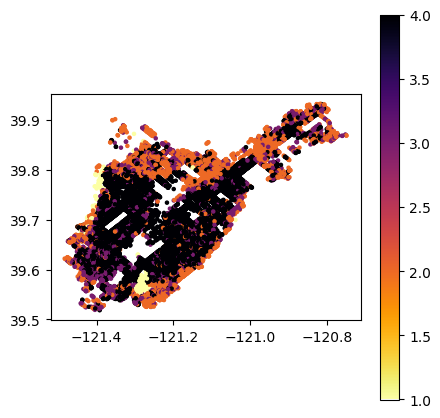

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
geo_plot(matches, ax, 'burn_severity_median', vmin=1, vmax=4)

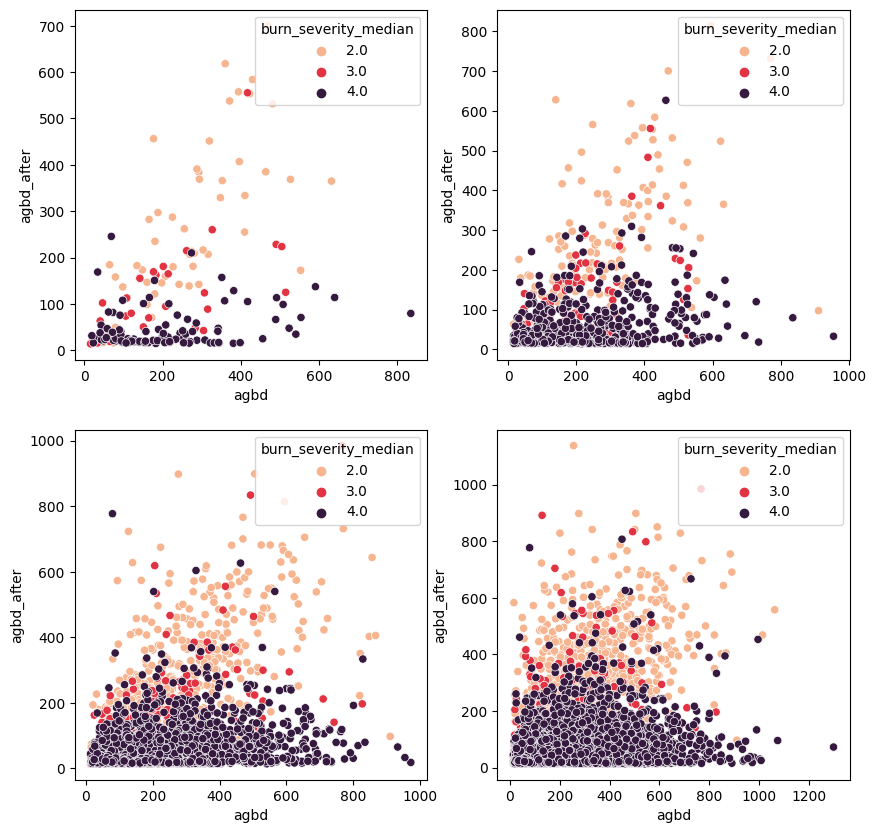

In [13]:
matching_analysis.plot_severity_for_distance(matches, 'agbd')

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


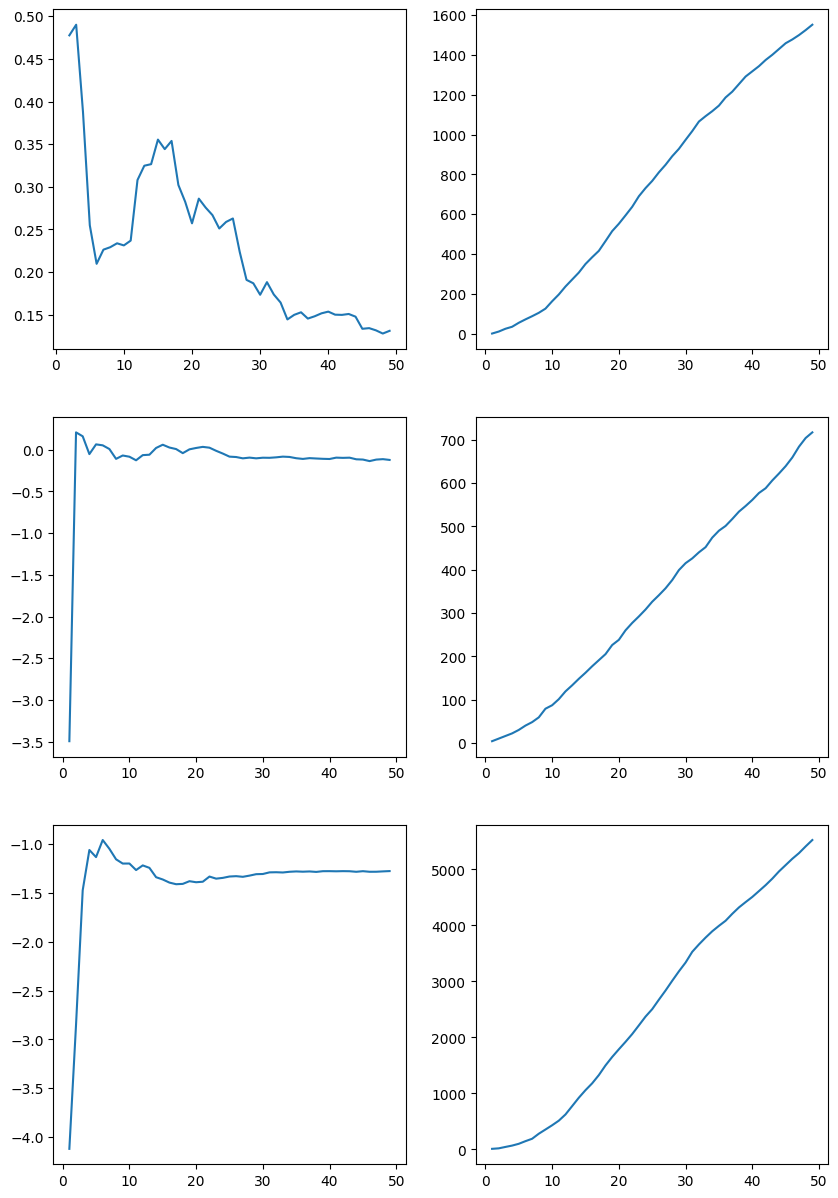

In [14]:
matching_analysis.plot_error_for_distances(matches, 'agbd')

In [15]:
def filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1) & (df.pft_class == 1)]

In [16]:
close_matches = filter_land_cover(matches[matches.closest_distance < 20])

Linear regression fit for severity 2.
Best Linear regression coefficient is [0.61673489].         R squared is : 0.34871733421023376.
The error for coeff = 1 is: 0.1357356348212735.
Linear regression fit for severity 3.
Best Linear regression coefficient is [0.4628302].         R squared is : 0.2647857796185189.
The error for coeff = 1 is: -0.09620532766338719.
Linear regression fit for severity 4.
Best Linear regression coefficient is [0.07885102].         R squared is : 0.040760987980120955.
The error for coeff = 1 is: -1.4071974045107467.


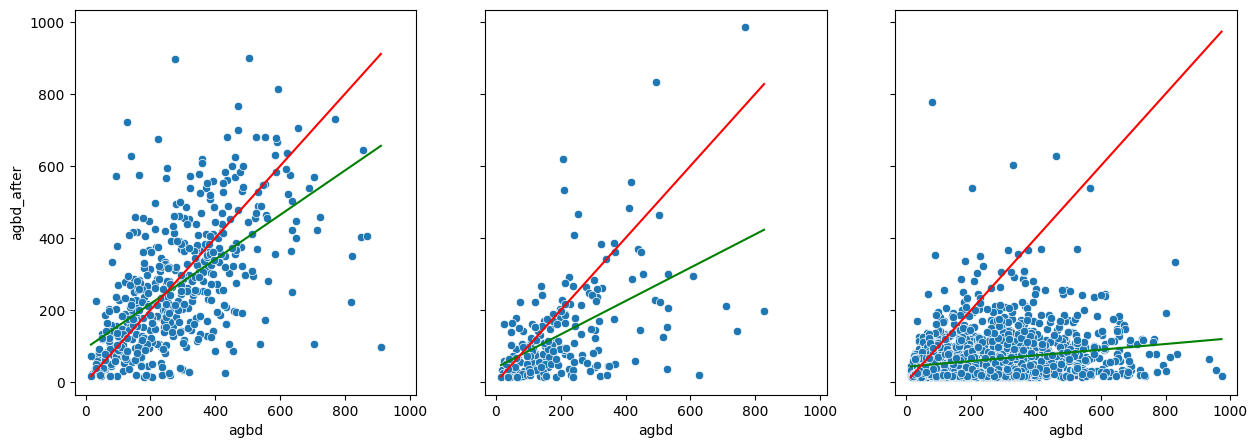

In [17]:
matching_analysis.fit_linear_regression_per_severity(close_matches, 'agbd')

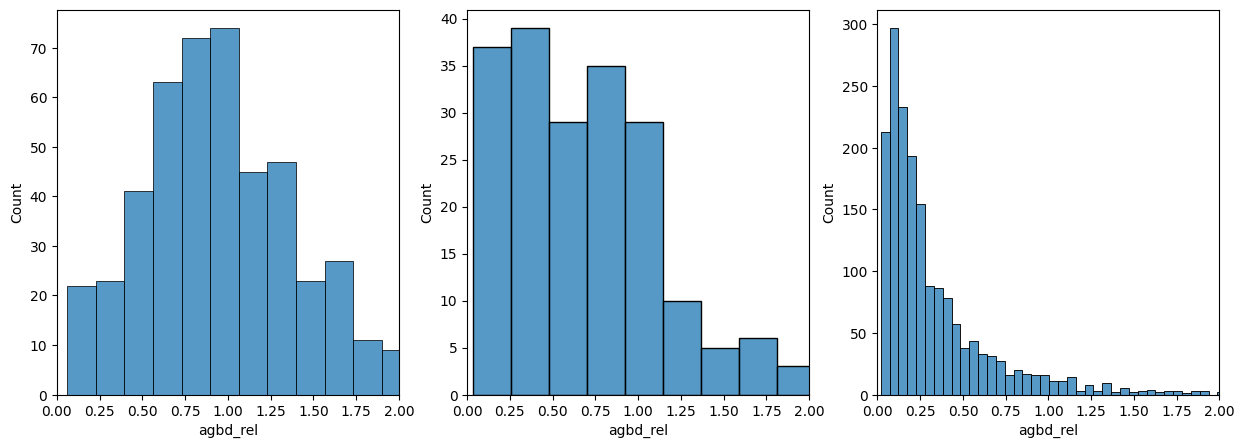

In [18]:
matching_analysis.plot_rel_difference_per_severity(close_matches, 'agbd')

### Fit distribution

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  7.17it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
beta            0.000021  1943.201926 -8351.663341     inf      0.073002   
gamma           0.000021  1929.734482 -8355.690585     inf      0.071810   
norm            0.000021  1954.220185 -8361.666102     inf      0.075221   
burr            0.000291  1834.784726 -7046.593706     inf      0.665936   
lognorm         0.000293  1844.645239 -7048.504605     inf      0.751415   

             ks_pvalue  
beta      9.910365e-03  
gamma     1.176305e-02  
norm      7.150529e-03  
burr     9.306491e-216  
lognorm  1.001296e-288  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 30.13it/s]


{'norm': {'loc': 13.827233277759978, 'scale': 153.1456068499971}}


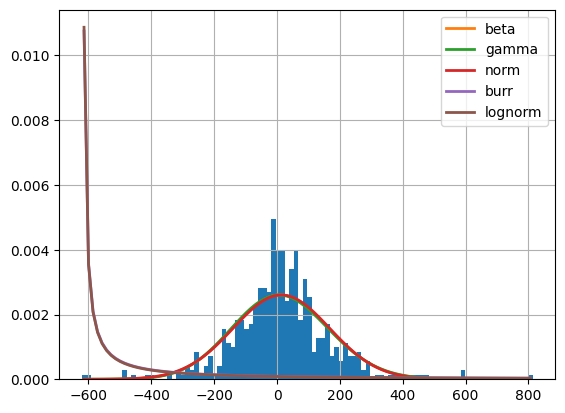

In [19]:
matching_analysis.fit_distributions(get_severity(close_matches, 2), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  7.79it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
lognorm         0.000111  1641.062973 -2911.109892     inf      0.123027   
gamma           0.000112  1639.689138 -2909.167548     inf      0.122255   
beta            0.000112  1639.851649 -2903.504445     inf      0.124243   
norm            0.000118  1629.130669 -2903.470937     inf      0.122239   
burr            0.000554  1766.576429 -2579.319548     inf      0.643070   

            ks_pvalue  
lognorm  3.893755e-03  
gamma    4.209067e-03  
beta     3.441242e-03  
norm     4.215737e-03  
burr     2.797734e-82  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 28.92it/s]


{'norm': {'loc': 70.37507242757111, 'scale': 143.36076348013808}}


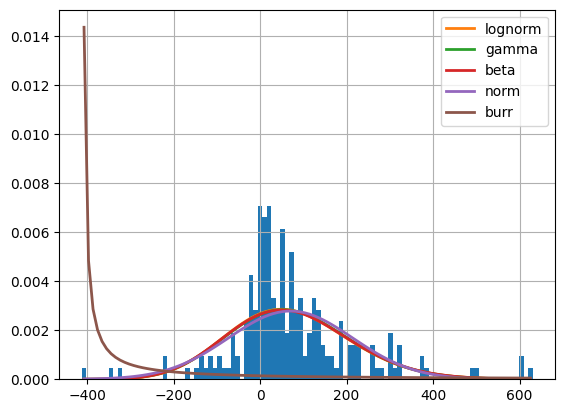

In [20]:
matching_analysis.fit_distributions(get_severity(close_matches, 3), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  6.69it/s]


         sumsquare_error          aic           bic  kl_div  ks_statistic  \
lognorm         0.000007  2435.714497 -34388.203535     inf      0.046032   
gamma           0.000007  2365.085743 -34252.352272     inf      0.048265   
beta            0.000007  2355.070812 -34206.448625     inf      0.048371   
burr            0.000008  3658.374754 -34019.907905     inf      0.073029   
norm            0.000010  2089.160724 -33736.415566     inf      0.059630   

            ks_pvalue  
lognorm  1.055255e-03  
gamma    4.990590e-04  
beta     4.811980e-04  
burr     1.142376e-08  
norm     6.370907e-06  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 29.32it/s]


{'norm': {'loc': 192.84172175095972, 'scale': 161.84629100440833}}


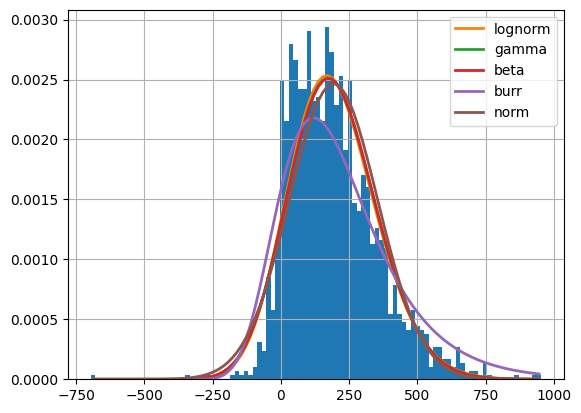

In [21]:
matching_analysis.fit_distributions(get_severity(close_matches, 4), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 17.48it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
burr            0.446117   846.159518 -3429.985974     inf      0.029008   
lognorm         0.619971   910.797588 -3273.944308     inf      0.046258   
beta            0.729720  1037.298315 -3187.390281     inf      0.061583   
gamma           0.750650  1019.438399 -3179.649936     inf      0.063043   
norm            1.509971  1904.439388 -2841.289294     inf      0.140474   

            ks_pvalue  
burr     7.898346e-01  
lognorm  2.347629e-01  
beta     4.555525e-02  
gamma    3.802839e-02  
norm     5.977967e-09  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 30.95it/s]


{'norm': {'loc': 1.0973535704239867, 'scale': 0.761675869940266}}


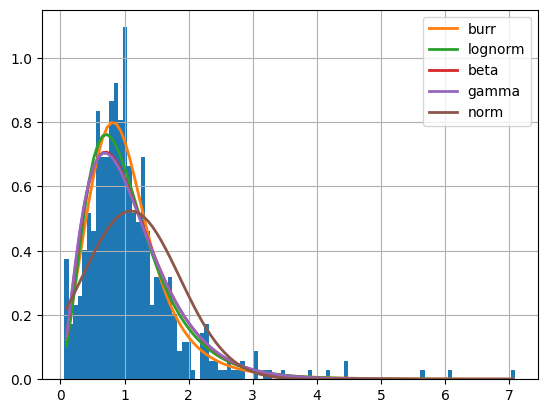

In [25]:
matching_analysis.fit_distributions(get_severity(close_matches, 2), 'agbd', rel=True)

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  9.89it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
burr            1.156668   836.820992 -1027.782616     inf      0.040859   
beta            1.240009   910.741470 -1013.658939     inf      0.066886   
lognorm         1.459966   796.885555  -985.823395     inf      0.069321   
norm            2.857158  1947.199012  -854.839435     inf      0.156165   
gamma           3.865193   791.934936  -788.182840     inf      0.166266   

         ks_pvalue  
burr      0.872987  
beta      0.309948  
lognorm   0.270760  
norm      0.000086  
gamma     0.000023  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 32.14it/s]


{'norm': {'loc': 0.7989422385581949, 'scale': 0.7215968153961064}}


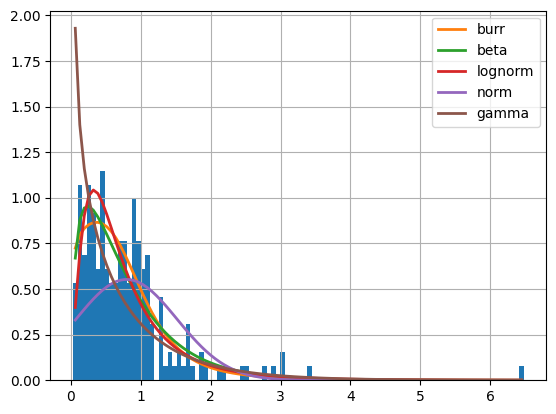

In [26]:
matching_analysis.fit_distributions(get_severity(close_matches, 3), 'agbd', rel=True)

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  9.35it/s]


         sumsquare_error           aic           bic  kl_div  ks_statistic  \
burr            0.127441   1117.869705 -16885.437738     inf      0.023463   
lognorm         0.282091   1289.536933 -15484.133184     inf      0.014156   
beta            0.452843   2722.698328 -14637.465359     inf      0.089786   
gamma           5.933145    719.512403 -10083.435042     inf      0.308965   
norm            8.083272  12013.164833  -9542.628810     inf      0.243875   

             ks_pvalue  
burr      2.787984e-01  
lognorm   8.643034e-01  
beta      6.909164e-13  
gamma    8.540042e-151  
norm      2.503129e-93  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 31.39it/s]


{'norm': {'loc': 0.3623400382250408, 'scale': 0.4874366284559726}}


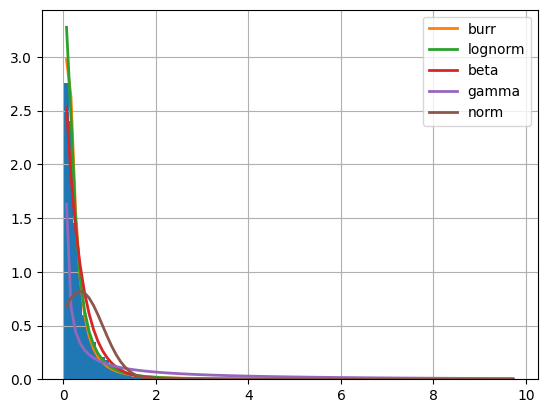

In [27]:
matching_analysis.fit_distributions(get_severity(close_matches, 4), 'agbd', rel=True)

### Stat tests

In [22]:
matching_analysis.two_sided_tests(get_severity(close_matches, 2), 'agbd')

Shapiro test results ShapiroResult(statistic=0.9574987888336182, pvalue=1.0102031017256152e-10)
Ttest results: TtestResult(statistic=2.0026880118061854, pvalue=0.045758972618042994, df=492)
Wilcoxon test results: WilcoxonResult(statistic=54255.0, pvalue=0.03616140382320999)


In [23]:
matching_analysis.two_sided_tests(get_severity(close_matches, 3), 'agbd')

Shapiro test results ShapiroResult(statistic=0.91289222240448, pvalue=1.4690358929314584e-09)
Ttest results: TtestResult(statistic=6.976927889880667, pvalue=4.226930420951405e-11, df=202)
Wilcoxon test results: WilcoxonResult(statistic=4162.0, pvalue=1.494502130424722e-13)


In [24]:
matching_analysis.two_sided_tests(get_severity(close_matches, 4), 'agbd')

Shapiro test results ShapiroResult(statistic=0.9594182968139648, pvalue=7.651712986412545e-22)
Ttest results: TtestResult(statistic=50.15683316260997, pvalue=0.0, df=1772)
Wilcoxon test results: WilcoxonResult(statistic=32083.0, pvalue=4.105764793552366e-268)


## PAI Analysis

In [31]:
matches_l2b = gedi_matching.match_measurements_before_and_after_fire(fire, gedi_burned_l2b, 'pai')

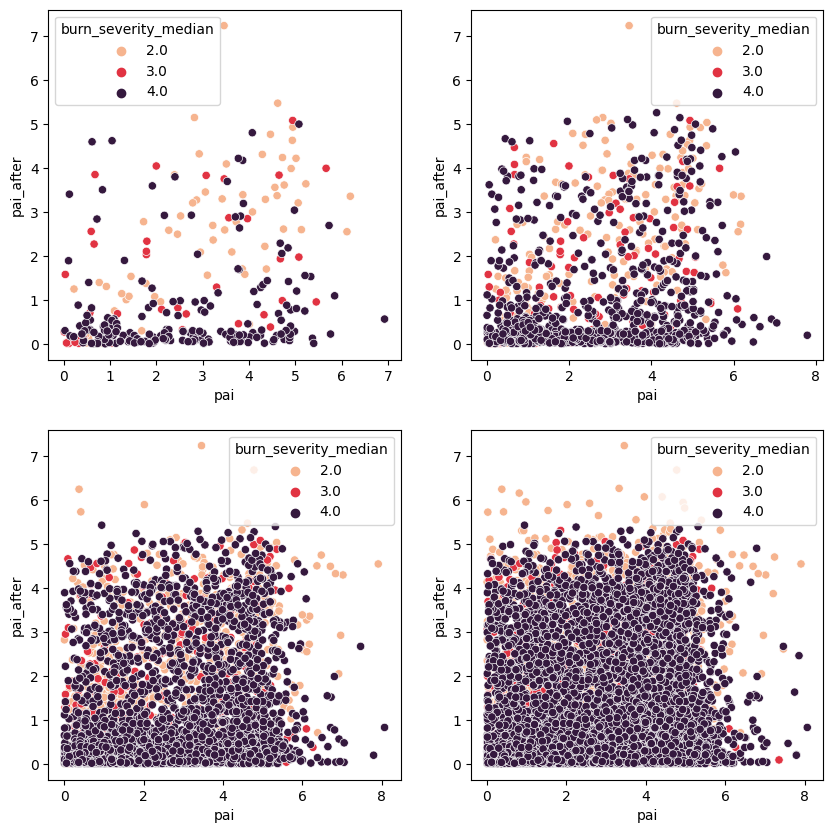

In [32]:
matching_analysis.plot_severity_for_distance(matches_l2b, 'pai')

In [33]:
def l2b_filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1)]

In [34]:
close_matches = l2b_filter_land_cover(matches_l2b[matches_l2b.closest_distance < 10])

In [36]:
close_matches['date_since'] = ((close_matches.match_datetime - fire.cont_date)/np.timedelta64(1, 'M')).astype(int)

Linear regression fit for severity 2.
Best Linear regression coefficient is [0.44572461].         R squared is : 0.24083819566496445.
The error for coeff = 1 is: -0.01955961878102319.
Linear regression fit for severity 3.
Best Linear regression coefficient is [0.26874941].         R squared is : 0.10404717187729218.
The error for coeff = 1 is: -0.522231654744219.
Linear regression fit for severity 4.
Best Linear regression coefficient is [0.13365482].         R squared is : 0.03104098477046935.
The error for coeff = 1 is: -1.3749523890986568.


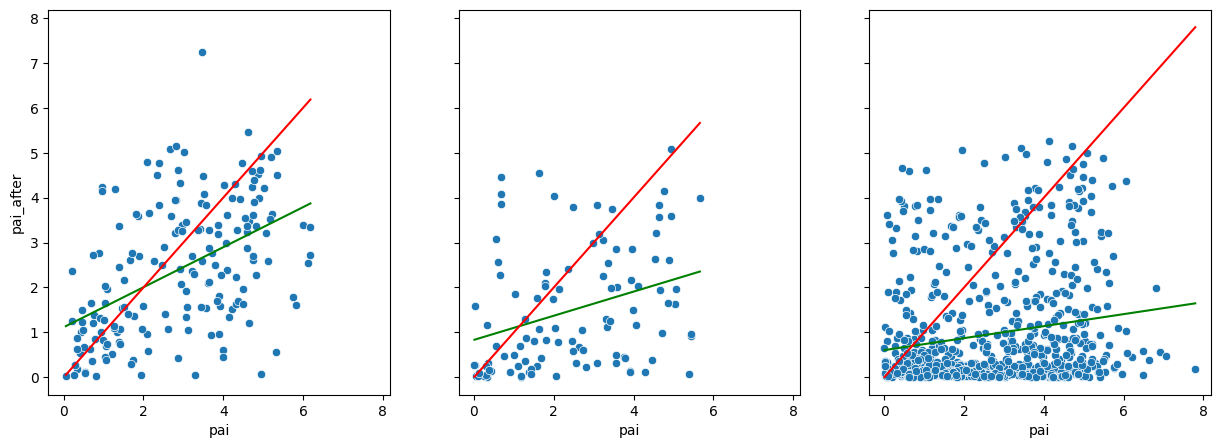

In [37]:
matching_analysis.fit_linear_regression_per_severity(close_matches, 'pai')

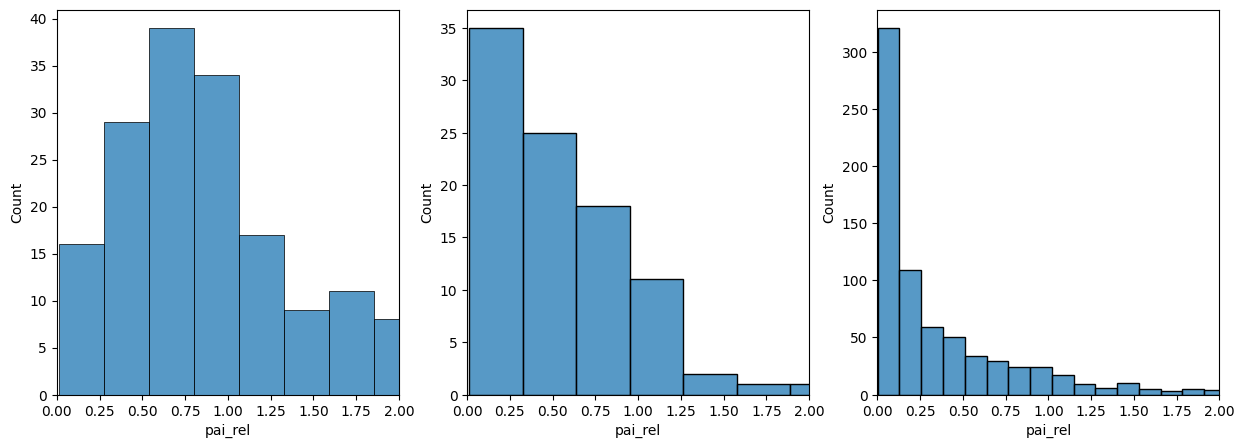

In [38]:
matching_analysis.plot_rel_difference_per_severity(close_matches, 'pai')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  5.82it/s]


         sumsquare_error         aic         bic  kl_div  ks_statistic  \
burr            0.885637  539.521574 -923.248063     inf      0.042841   
beta            0.920970  534.664333 -916.284712     inf      0.047784   
lognorm         0.921686  532.775000 -921.328231     inf      0.049815   
gamma           0.921973  532.731836 -921.272666     inf      0.050014   
norm            0.927829  530.504877 -925.327427     inf      0.057201   

         ks_pvalue  
burr      0.885409  
beta      0.792807  
lognorm   0.749729  
gamma     0.745405  
norm      0.584854  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


{'norm': {'loc': 0.4783862015842697, 'scale': 1.5751968106680188}}


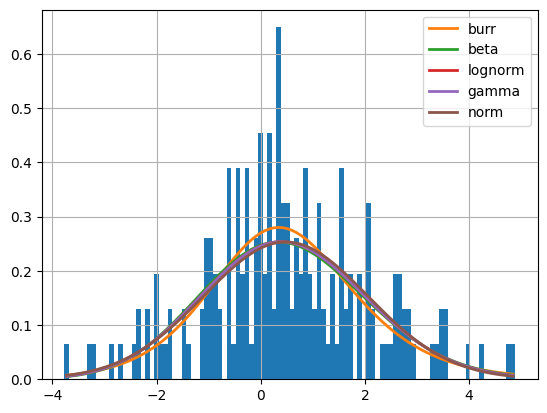

In [39]:
matching_analysis.fit_distributions(get_severity(close_matches, 2), 'pai')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  5.74it/s]


         sumsquare_error         aic         bic  kl_div  ks_statistic  \
burr            0.969469  541.902050 -467.663819     inf      0.072077   
lognorm         1.002186  531.196192 -468.856423     inf      0.093402   
gamma           1.002788  530.103122 -468.793928     inf      0.098078   
norm            1.004186  528.052845 -473.293400     inf      0.093259   
beta            1.013708  531.038646 -463.023104     inf      0.090124   

         ks_pvalue  
burr      0.626008  
lognorm   0.305172  
gamma     0.252808  
norm      0.306881  
beta      0.346113  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

{'norm': {'loc': 0.9794782436249998, 'scale': 1.7422833094803887}}


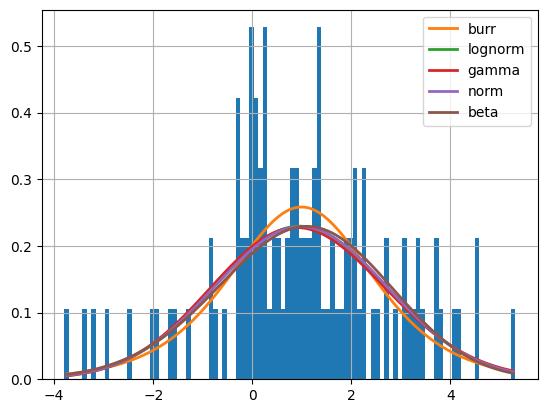

In [40]:
matching_analysis.fit_distributions(get_severity(close_matches, 3), 'pai')

Fitting 5 distributions: 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]


         sumsquare_error         aic          bic  kl_div  ks_statistic  \
gamma           0.159105  637.599303 -6456.328443     inf      0.037785   
lognorm         0.161283  640.307337 -6445.940616     inf      0.037167   
norm            0.162276  637.093939 -6447.890352     inf      0.037348   
beta            0.167998  645.708059 -6408.138892     inf      0.042517   
burr            0.201521  656.031113 -6269.134156     inf      0.081106   

         ks_pvalue  
gamma     0.219812  
lognorm   0.235969  
norm      0.231144  
beta      0.122719  
burr      0.000081  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

{'norm': {'loc': 1.720537506250262, 'scale': 1.9052859626188647}}


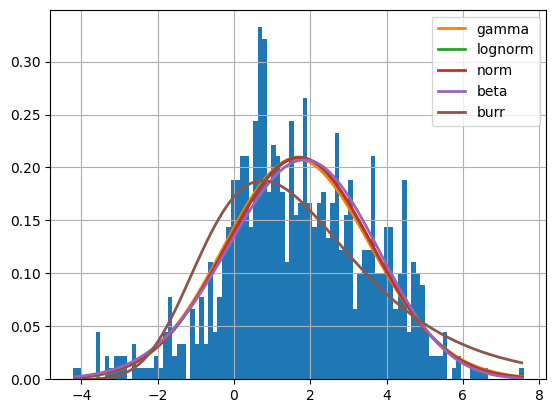

In [41]:
matching_analysis.fit_distributions(get_severity(close_matches, 4), 'pai')

## PAI Z Analysis

In [42]:
from src.data import pai_vertical
importlib.reload(gedi_matching)
importlib.reload(pai_vertical)

<module 'src.data.pai_vertical' from '/home/jk871/fire-regen/src/data/pai_vertical.py'>

In [43]:
matches_paiz = gedi_matching.match_pai_z_before_and_after_fire(fire, gedi_burned_l2b)

Index(['shot_number', 'absolute_time', 'lon_lowestmode', 'lat_lowestmode',
       'fhd_normal', 'pai', 'pai_z', 'pavd_z', 'rh100', 'cover', 'cover_z',
       'beam_type', 'sensitivity', 'gridded_pft_class', 'geometry',
       'burn_severity_2x2', 'burn_severity_mean', 'burn_severity_std',
       'burn_severity_median', 'burn_year_2x2', 'burn_year_mean',
       'burn_year_std', 'burn_year_median', 'burn_counts_2x2',
       'burn_counts_mean', 'burn_counts_std', 'burn_counts_median',
       'land_cover_2x2', 'land_cover_mean', 'land_cover_std',
       'land_cover_median', 'gedi_year', 'gedi_month', 'time_since_burn',
       'index_right', 'YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME',
       'INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'COMMENTS', 'REPORT_AC',
       'GIS_ACRES', 'C_METHOD', 'OBJECTIVE', 'FIRE_NUM', 'Shape_Length',
       'Shape_Area', 'COMPLEX_NAME', 'COMPLEX_INCNUM', 'FID', 'pai_z_np',
       'pai_z_padded', 'pai_z_delta_np'],
      dtype='object')
1
2
3


In [44]:
close_matches = l2b_filter_land_cover(matches_paiz[matches_paiz.closest_distance < 10])

In [56]:
def get_pai_z_df(df, severity):
    lala = get_severity(df, severity).pai_z_delta_diff.to_numpy()
    new_lala = np.empty((lala.shape[0], lala[0].shape[0]))

    for i in range(lala.shape[0]):
        new_lala[i] = lala[i]

    return pd.melt(pd.DataFrame(new_lala))

(0.0, 13.0)

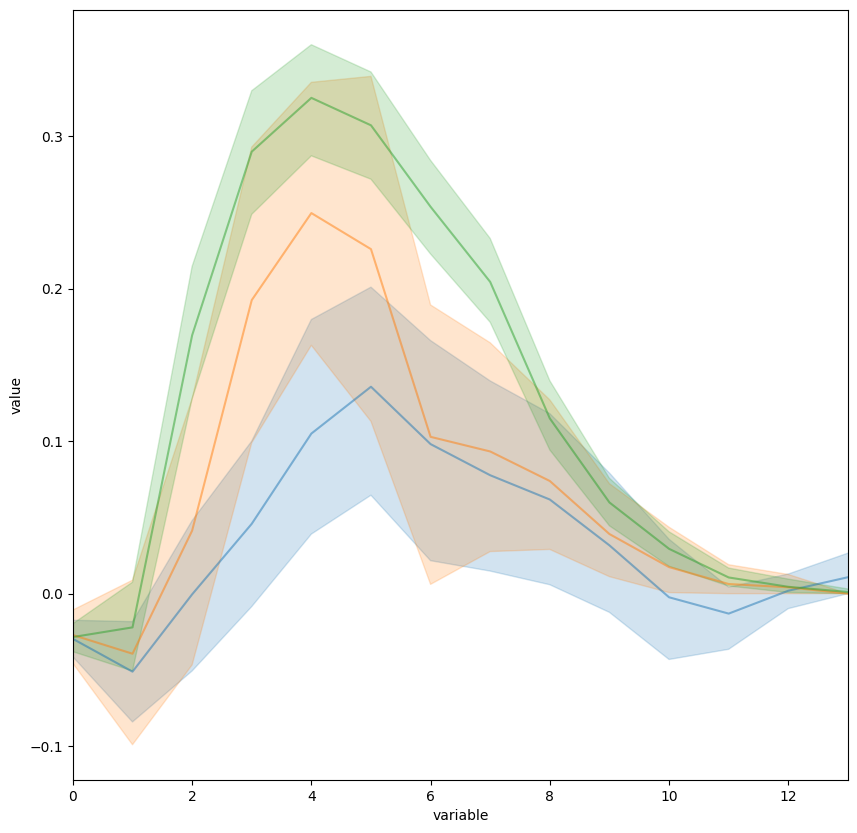

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(get_pai_z_df(close_matches, 2), x='variable', y='value', ax=ax, alpha=0.5)
sns.lineplot(get_pai_z_df(close_matches, 3), x='variable', y='value', ax=ax, alpha=0.5)
sns.lineplot(get_pai_z_df(close_matches, 4), x='variable', y='value', ax=ax, alpha=0.5)
ax.set_xlim((0, 13))

In [50]:
close_matches['date_since'] = ((close_matches.match_datetime - fire.cont_date)/np.timedelta64(1, 'M')).astype(int)

(0.0, 13.0)

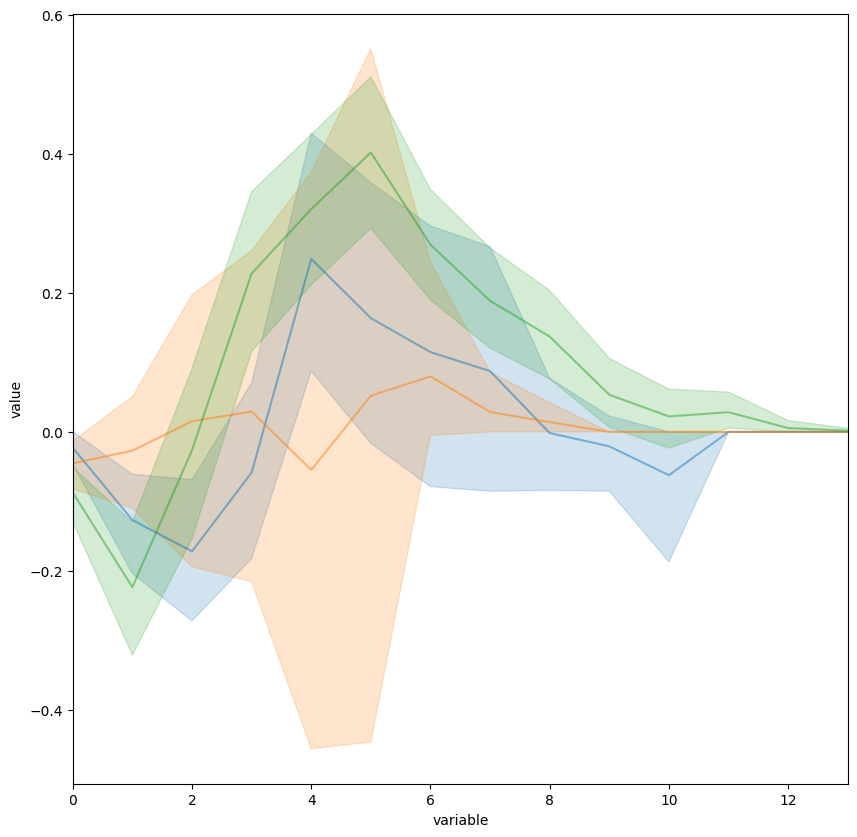

In [59]:
bla = close_matches[close_matches.date_since < 12]
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(get_pai_z_df(bla, 2), x='variable', y='value', ax=ax, alpha=0.5)
sns.lineplot(get_pai_z_df(bla, 3), x='variable', y='value', ax=ax, alpha=0.5)
sns.lineplot(get_pai_z_df(bla, 4), x='variable', y='value', ax=ax, alpha=0.5)
ax.set_xlim((0, 13))

(0.0, 13.0)

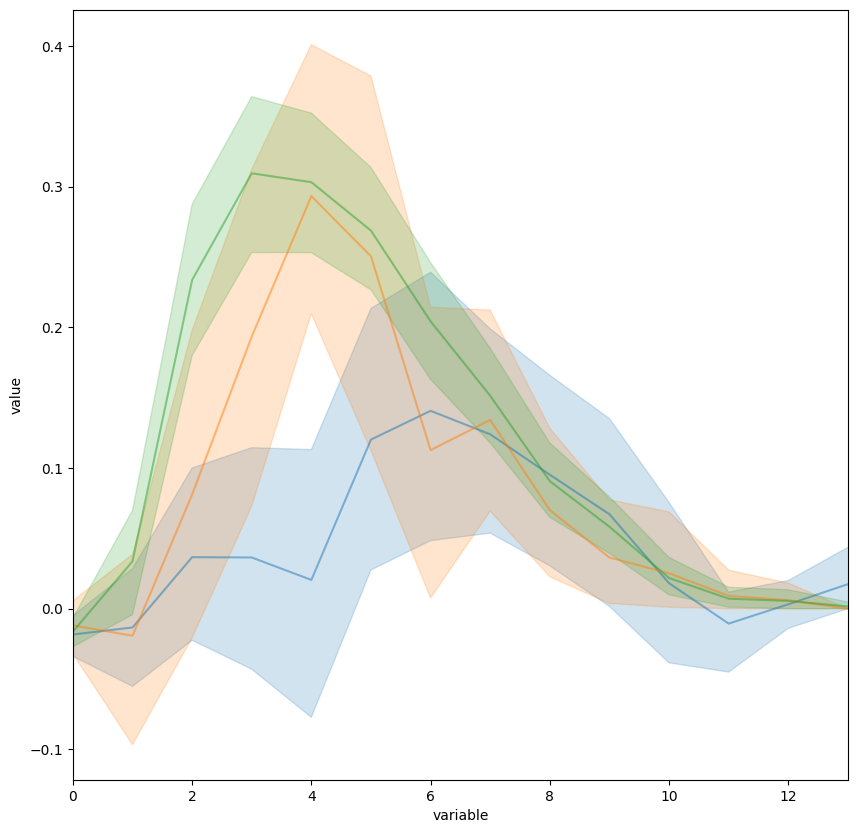

In [60]:
bla = close_matches[close_matches.date_since > 18]
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(get_pai_z_df(bla, 2), x='variable', y='value', ax=ax, alpha=0.5)
sns.lineplot(get_pai_z_df(bla, 3), x='variable', y='value', ax=ax, alpha=0.5)
sns.lineplot(get_pai_z_df(bla, 4), x='variable', y='value', ax=ax, alpha=0.5)
ax.set_xlim((0, 13))

In [51]:
close_matches.date_since

8636267     21
8636273      8
8636371      8
8636452     21
8636454     21
            ..
20749337    17
20749478    13
20749483    13
20753889    13
20753900    13
Name: date_since, Length: 1050, dtype: int64